In [1]:
import openpyxl
import matplotlib as mp
import matplotlib.pyplot as plt
import sklearn as sl
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
import xgboost as xgb
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel

In [2]:
AA="C:/Users/ganes/onedrive/Desktop/AI/NCCO2R/NC-Final.xlsx"
df=pd.read_excel(AA)
df.head(5)
df=pd.read_excel(AA)
df.head(5)
df.shape 

(477, 22)

In [3]:
X = pd.read_excel(AA, usecols='A:P') 
Y=pd.read_excel(AA, usecols='Q')


In [4]:
Y.head(5)

,H2
0,22.333333
1,22.333333
2,22.000000
3,28.666667
4,32.000000


In [5]:
import seaborn as sns

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y.values.ravel(), test_size=0.2, random_state=22)

# Feature selection using a simple model
selector = SelectFromModel(RandomForestRegressor(n_estimators=200, random_state=22))
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Define base models for stacking with regularization parameters
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, random_state=22)),
    ('xgb', xgb.XGBRegressor(n_estimators=400, max_depth=2, learning_rate=0.2,
                              reg_lambda=2, reg_alpha=1, random_state=22)),  # Adjusted parameters
]

# Define the meta-model
meta_model = LinearRegression()

# Create the Stacking Regressor
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)


# Fit the best model on the entire training set for final evaluation
stacked_model.fit(X_train_selected, y_train)

# Training performance metrics
y_train_pred = stacked_model.predict(X_train_selected)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Print performance metrics for the training set
print(f"Training RMSE: {train_rmse}")
print(f"Training R²: {train_r2}")
print(f"Training MAE: {train_mae}")

# Make predictions on the test set
y_test_pred = stacked_model.predict(X_test_selected)

# Evaluate performance metrics for the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print performance metrics for the test set
print(f"Test RMSE: {test_rmse}")
print(f"Test R²: {test_r2}")
print(f"Test MAE: {test_mae}")

param_grid = {
    'xgb__max_depth': [2, 3],  # Reduced complexity
    'xgb__learning_rate': [0.1, 0.2,],
    'xgb__reg_lambda': [2, 3],  # Regularization options
    'xgb__reg_alpha': [0.5, 1], # Added L1 regularization options
    'xgb__n_estimators': [100, 200, ], # Added L1 regularization options
}

# Create GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(stacked_model, param_grid, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search.fit(X_train_selected, y_train)

# Retrieve the best model and parameters
best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

# Evaluate performance on the training set with the best model
y_train_pred_best = best_model.predict(X_train_selected)
train_rmse_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
train_r2_best = r2_score(y_train, y_train_pred_best)
train_mae_best = mean_absolute_error(y_train, y_train_pred_best)

# Print performance metrics for the training set with the best model
print(f"Best Model Training RMSE: {train_rmse_best}")
print(f"Best Model Training R²: {train_r2_best}")
print(f"Best Model Training MAE: {train_mae_best}")

# Evaluate performance on the test set with the best model
y_test_pred_best = best_model.predict(X_test_selected)
test_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
test_r2_best = r2_score(y_test, y_test_pred_best)
test_mae_best = mean_absolute_error(y_test, y_test_pred_best)

# Print performance metrics for the test set with the best model
print(f"Best Model Test RMSE: {test_rmse_best}")
print(f"Best Model Test R²: {test_r2_best}")
print(f"Best Model Test MAE: {test_mae_best}")



Training RMSE: 4.219257517025412
Training R²: 0.9733160865479323
Training MAE: 3.0920208280047405
Test RMSE: 8.58668907188419
Test R²: 0.879769792964541
Test MAE: 5.9549261775427835
Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best parameters found:  {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 1, 'xgb__reg_lambda': 2}
Best Model Training RMSE: 3.786688467496518
Best Model Training R²: 0.978507021128752
Best Model Training MAE: 2.8252824524513467
Best Model Test RMSE: 8.507414038446106
Best Model Test R²: 0.8819795517730914
Best Model Test MAE: 6.117616033462191


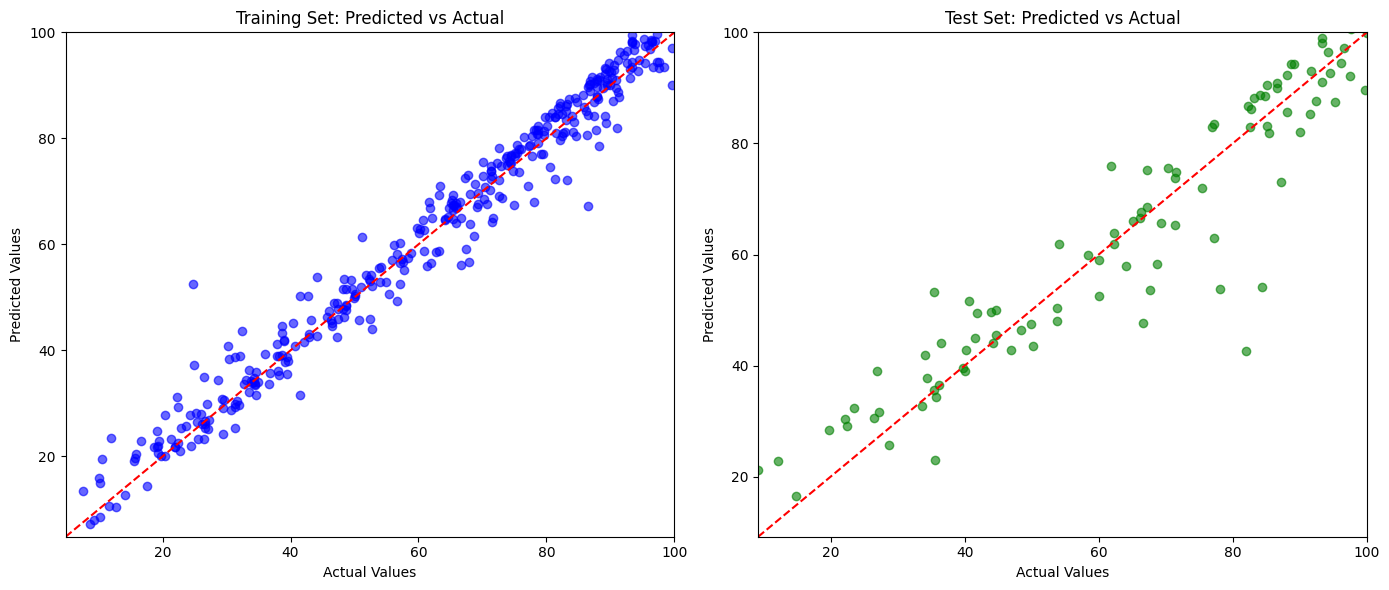

In [7]:
# Scatter plot for training set predictions
plt.figure(figsize=(14, 6))

# Training Set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')  # Diagonal line
plt.title('Training Set: Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim([y_train.min(), y_train.max()])
plt.ylim([y_train.min(), y_train.max()])

# Test Set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Diagonal line
plt.title('Test Set: Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim([y_test.min(), y_test.max()])
plt.ylim([y_test.min(), y_test.max()])

plt.tight_layout()
plt.show()

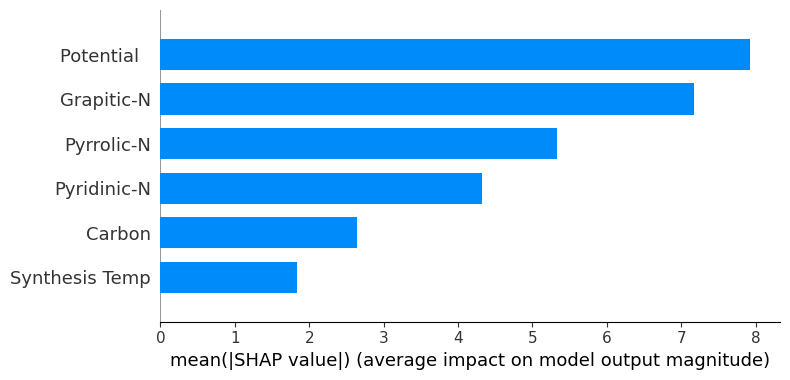

In [8]:
import shap
# Extract the XGBoost model from the stacked model
xgb_model = best_model.named_estimators_['xgb']

# Create SHAP TreeExplainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer.shap_values(X_test_selected)

# Plot the SHAP summary
shap.summary_plot(shap_values_xgb, X_test_selected, feature_names=X.columns[selector.get_support()], plot_type="bar")

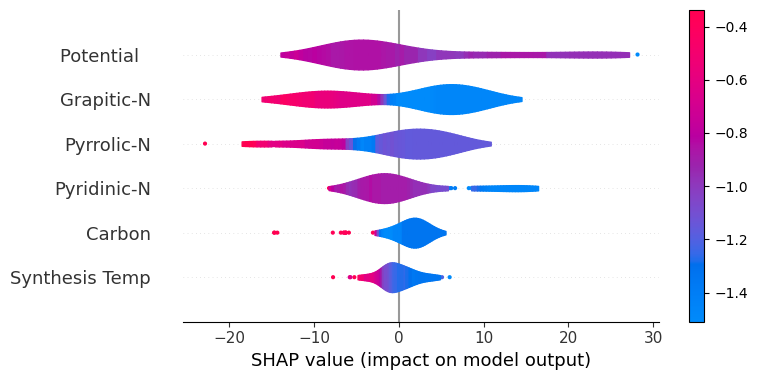

In [9]:
shap.summary_plot(shap_values_xgb, X_test_selected, feature_names=X.columns[selector.get_support()], show = False, color_bar = False, plot_type="violin")
plt.colorbar()
plt.show()